In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces

X,y = fetch_olivetti_faces(return_X_y=True)

In [2]:
X

array([[0.30991736, 0.3677686 , 0.41735536, ..., 0.15289256, 0.16115703,
        0.1570248 ],
       [0.45454547, 0.47107437, 0.5123967 , ..., 0.15289256, 0.15289256,
        0.15289256],
       [0.3181818 , 0.40082645, 0.49173555, ..., 0.14049587, 0.14876033,
        0.15289256],
       ...,
       [0.5       , 0.53305787, 0.607438  , ..., 0.17768595, 0.14876033,
        0.19008264],
       [0.21487603, 0.21900827, 0.21900827, ..., 0.57438016, 0.59090906,
        0.60330576],
       [0.5165289 , 0.46280992, 0.28099173, ..., 0.35950413, 0.3553719 ,
        0.38429752]], dtype=float32)

In [3]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 0.99)
X_pca = pca.fit_transform(X)

In [4]:
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split

In [5]:
n_classes = len(np.unique(y))

In [6]:
def makegm(cov_type, n_components): 
    return GaussianMixture(
            n_init=10, n_components=n_components, covariance_type=cov_type, max_iter=20, random_state=0,reg_covar=1e-5
    )

In [7]:
cmap = plt.cm.get_cmap('hsv', n_classes)
colors = [cmap(i) for i in range(n_classes)]
    
def make_ellipses(gmm):
    ax = plt.axes()
    for n, color in enumerate(colors):
        if gmm.covariance_type == "spherical":
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        elif gmm.covariance_type == "diag":
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == "tied":
            covariances = gmm.covariances_[:2, :2]           
        elif gmm.covariance_type == "full":
            covariances = gmm.covariances_[n][:2, :2]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        ell = mpl.patches.Ellipse(
            gmm.means_[n, :2], v[0], v[1], 180 + angle, color=color
        )
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        ax.set_aspect("equal", "datalim")

In [8]:
covariance_types = ["spherical", "diag", "tied", "full"]

In [9]:
# Break up the dataset into non-overlapping training (75%) and testing (25%) sets.
X_train, X_test, y_train, y_test = train_test_split(X_pca,y,test_size=0.25,stratify=y)

profiles = []
for cov_type in covariance_types:
    profiles.append({
        'gm' : makegm(cov_type, n_classes),
        'predictions': []
    })

for p in profiles:
    # Since we have class labels for the training data, we can
    # initialize the GMM parameters in a supervised manner.
    estimator = p['gm']
    estimator.means_init = np.array(
        [X_train[y_train == i].mean(axis=0) for i in range(n_classes)]
    )
    estimator.fit(X_train)
    p['predictions'] = estimator.predict(X_test)

In [10]:
best_covariance_type = None
for p in profiles:
    score = np.mean(p['predictions'].ravel() == y_test.ravel())
    if best_covariance_type is None:
        best_covariance_type = p['gm'], score
    else:
        _, last_score = best_covariance_type
        if last_score < score:
            best_covariance_type = (p['gm'], score)

best_gm, best_score = best_covariance_type
print(f'Best covariance type --> {best_gm.covariance_type} with score = {best_score}')

Best covariance type --> full with score = 0.83


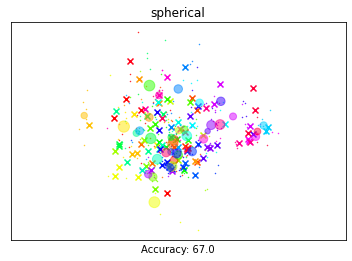

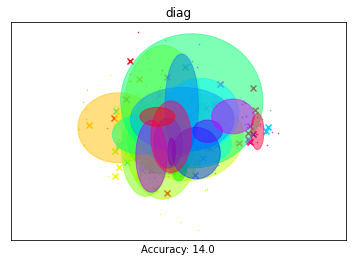

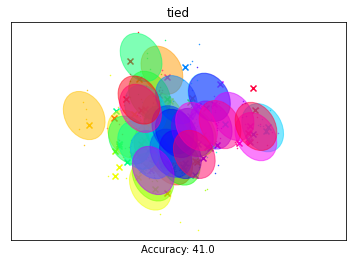

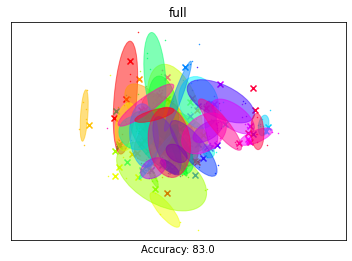

In [11]:
for p in profiles:
    make_ellipses(p['gm'])
    
    for n, color in enumerate(colors):
        data = X_train[y_train == n]
        plt.scatter(data[:, 0], data[:, 1], s=0.8, color=color,marker=".")
    # Plot the test data with crosses
    for n, color in enumerate(colors):
        data = X_test[y_test == n]
        plt.scatter(data[:, 0], data[:, 1], color=color, marker="x")
    test_accuracy = np.mean(p['predictions'].ravel() == y_test.ravel()) * 100
    plt.xlabel("Accuracy: %.1f" % test_accuracy)

    plt.xticks(())
    plt.yticks(())
    plt.title(p['gm'].covariance_type)
    plt.show()    

In [12]:
n_components_list = [2,3,4,5,6,7,8,9,10,15,20,30,40,50]

In [13]:
profiles = [{'gms': [makegm(c,n) for n in n_components_list], 'best_n': 0} for c in covariance_types]
for p in profiles:
    score = np.Inf
    for m in p['gms']:
        m.fit(X_pca)
        s = m.aic(X_pca)
        if s < score:
            score = s
            p['best_n'] = m.n_components
    best_model = next(m for m in p['gms'] if m.n_components == p['best_n'])        
    print(f"GaussianMixture Model with covariance_type = {p['gms'][0].covariance_type} --> # of clusters: {p['best_n']}, converged: {best_model.converged_}")        
    

GaussianMixture Model with covariance_type = spherical --> # of clusters: 50, converged: True
GaussianMixture Model with covariance_type = diag --> # of clusters: 3, converged: True
GaussianMixture Model with covariance_type = tied --> # of clusters: 50, converged: True
GaussianMixture Model with covariance_type = full --> # of clusters: 5, converged: True


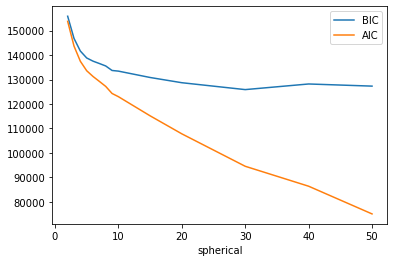

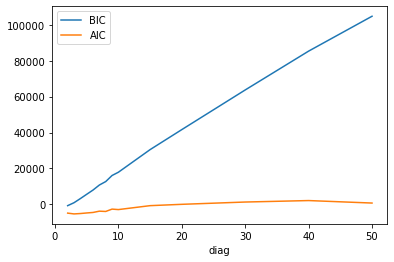

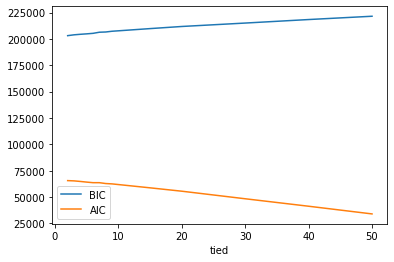

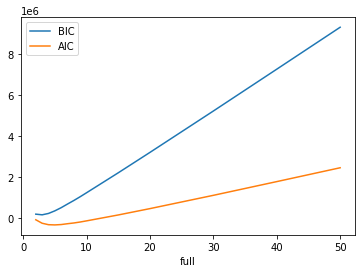

In [14]:
for p in profiles:
    plt.plot(n_components_list, [m.bic(X_pca) for m in p['gms']], label='BIC')
    plt.plot(n_components_list, [m.aic(X_pca) for m in p['gms']], label='AIC')
    plt.legend(loc='best')
    plt.xlabel(p['gms'][0].covariance_type)
    plt.show()

In [15]:
for p in profiles:
    best_model = next(m for m in p['gms'] if m.n_components == p['best_n'])
    print(f'Clusterings for covariance_type = {m.covariance_type}:')
    print(f'\nHard:\n{best_model.predict(X_pca)}')
    print(f'\nSoft:\n{best_model.predict_proba(X_pca)}')
    print()

Clusterings for covariance_type = full:

Hard:
[41  4 41 48 12 48 41 48 41 12 19 19 19 19 19 19 19 19 19 19  5  5  5 43
 43 43  8 43 12 12  2  2 43 12 12 48  2  2 19  4 29  7  7 29  8  8 29  8
  8  8 14 14 14 25 25 25 25 25 25 25 18 18 31 18 18 31 18 18 31 18 45 45
 45  4 45 45  4 45 48  4  3  7  3 29 29 29 29 29 29 12 33 33 33 33 33 33
 33 33 48  6  9  9  9  9  9  9  9  9  9  9 12 38 38 38 38  8 38 12 12 12
  2  2  2 29  2  4 48  8 12  2 21 21 21 21 21 21 21 21 21 21  2  2  2  2
  2  2  2  2  2  2 35 41 41 18 18 35  4 48 41 41  0  0 32 32  0 36 36  0
 36 36 24 24 24 24 24 24 24 24 24 24 49 49 49 22 22 49 22 22 22 49  7  7
  7  2 42  2 42 42 42  7  7  1  1  1  7  7  1  1  1  1 13 13 13 13 44 13
 44 44 44 44 12 12 11 29 11 29 29 12  8  8 39 39 37 37 39 39 39 39 37 37
 11 11 11 11 29 11 11 29 11 11 32 32 32  5  5 32 12  5 32  5 10 10 10 10
 10 10 10 10 10 10 26 23 26 26 23 26 23 26 23 26 28 40 28  1  1  1  1  1
 28 28  7  7  7  7  7  7  7  7  7  7  3 30 30 30 30  3  3  3  3 30 46 46
 46 

In [16]:
X_new, y_new=best_gm.sample(50)
pca.inverse_transform(X_new).shape

(50, 4096)

In [17]:
faces_new = np.array([i.reshape(64,64) for i in pca.inverse_transform(X_new)])

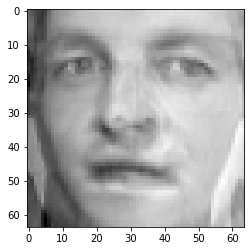

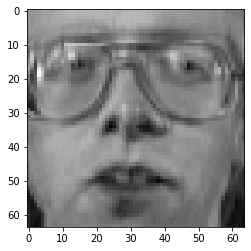

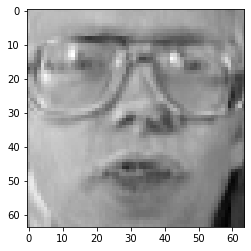

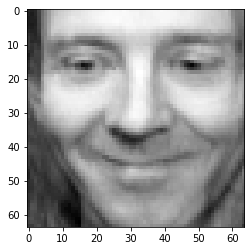

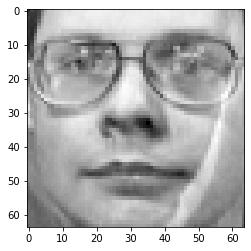

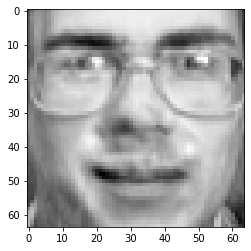

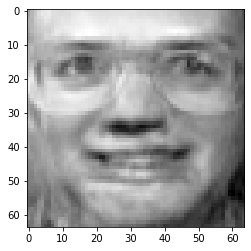

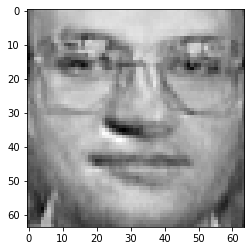

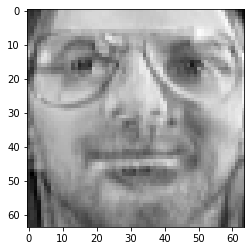

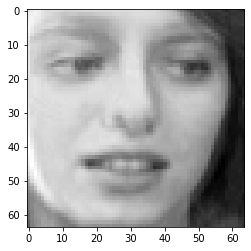

In [18]:
for img in faces_new[:10]:
    plt.imshow(img, cmap='gray')
    plt.show()

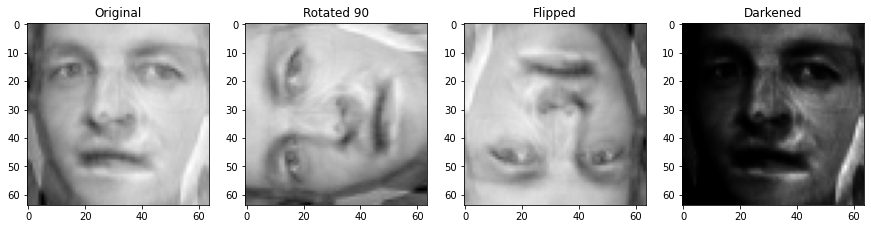

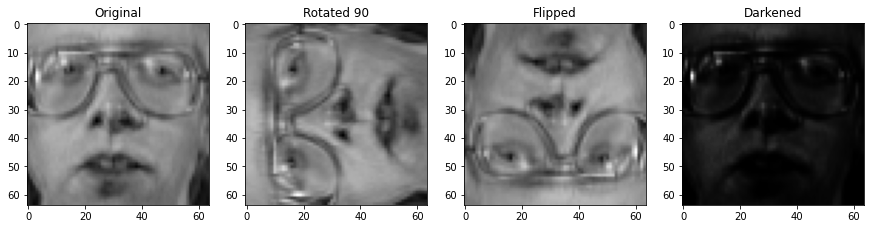

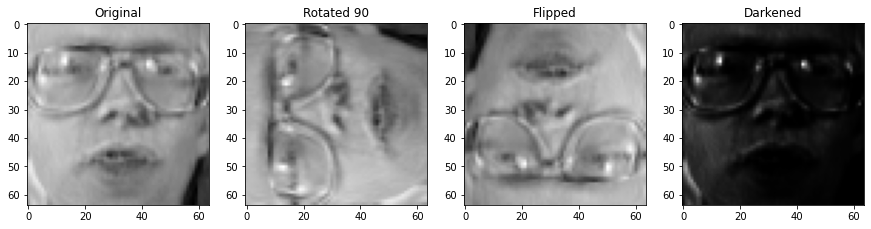

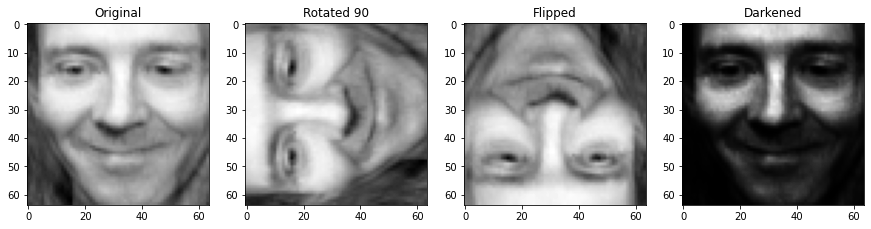

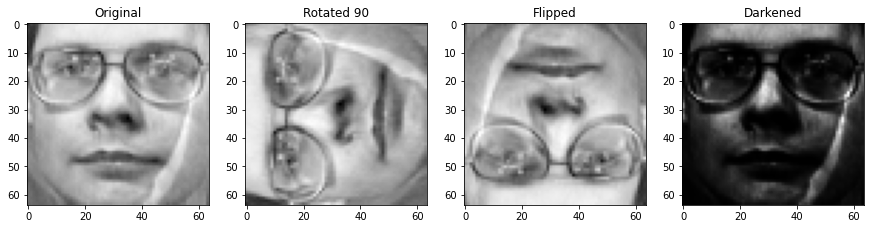

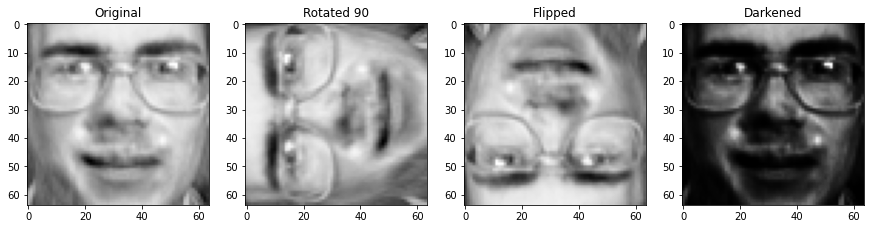

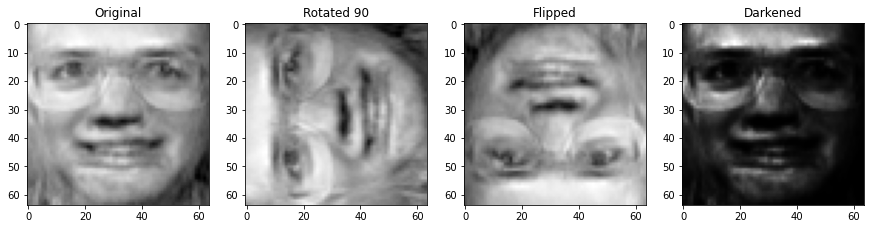

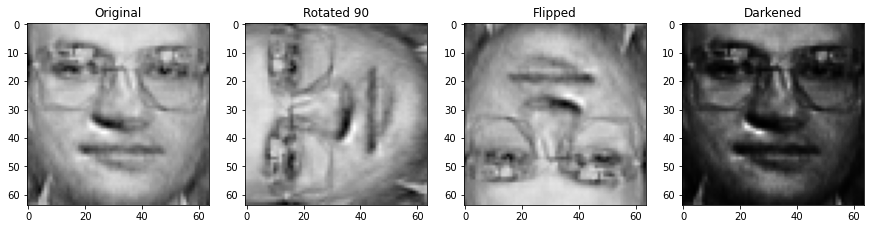

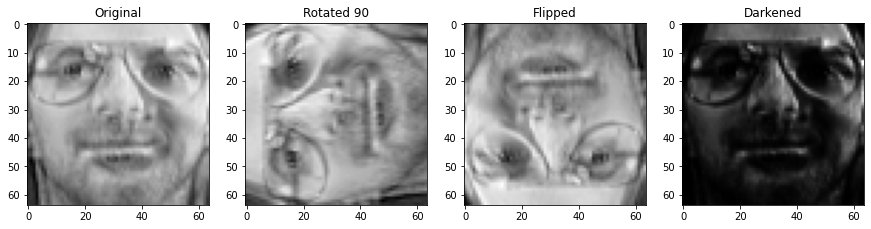

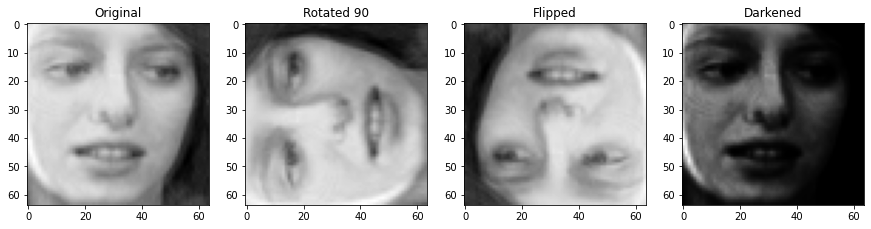

In [19]:
from scipy import ndimage

for img in faces_new[:10]:
    fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(15,15))

    ax1.imshow(img, cmap="gray")
    ax1.set_title("Original")
    
    ax2.imshow(ndimage.rotate(img, 90,mode = 'mirror'), cmap="gray")
    ax2.set_title('Rotated 90')
    
    ax3.imshow(ndimage.rotate(img, 180,mode = 'mirror'), cmap="gray")
    ax3.set_title('Flipped')
    
    ax4.imshow(np.power(img,5), cmap="gray")
    ax4.set_title('Darkened')
    
    plt.show()

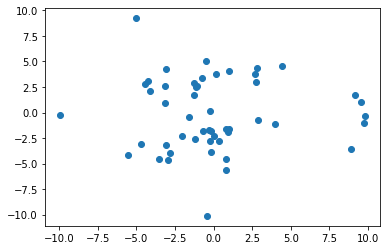

In [20]:
#plotting of sampled unmodified faces
plt.scatter(X_new[:,0], X_new[:,1])
plt.show()

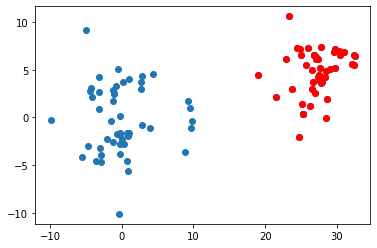

In [21]:
#scoring for sampled modified faces mixed with unmodified ones
X_bad = pca.transform(np.array([np.power(i,5) for i in pca.inverse_transform(X_new)]))
X_mixed = np.concatenate([X_new ,X_bad])
scores = best_gm.score_samples(X_mixed)
thresh = np.quantile(scores, .5)
index = np.where(scores <= thresh)
values = X_mixed[index]
plt.scatter(X_mixed[:,0], X_mixed[:,1])
plt.scatter(values[:,0],values[:,1], color='r')
plt.show()